In [1]:
from survae.data import *
from survae.layer import *
from survae.plot import *
from survae.train import *

# Default Datasets

We'll first compare the default network structure with alternating bijective/orthonormal layers to one that has an absolute layer at the beginning, which should theoretically improve performance on symmetrical datasets.

In [2]:
default_model_generators = [
    lambda: SurVAE(
        [
            [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2)]
            for _ in range(10)
        ],
        name="NF",
    ),
    lambda: SurVAE(
        [
            AbsoluteUnit(torch.tensor([1 / 2, 1 / 2])),
        ] + [
            [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2)]
            for _ in range(10)
        ],
        name="NF-abs",
    ),
    lambda: SurVAE(
        [
            AbsoluteUnit(torch.tensor([1 / 2, 1 / 2]), learn_q=True),
        ] + [
            [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2)]
            for _ in range(10)
        ],
        name="NF-abs-trained",
    )
]

In [3]:
default_datasets = [Ngon(), Circles(), Corners(), Checkerboard()]

In [10]:
models = train_models(default_model_generators, default_datasets)

100%|██████████| 12/12 [14:52<00:00, 74.39s/it]


As we can see, the performance for symmetric datasets of NF+abs is much better, whereas the performance for antisymmetric is terrible.

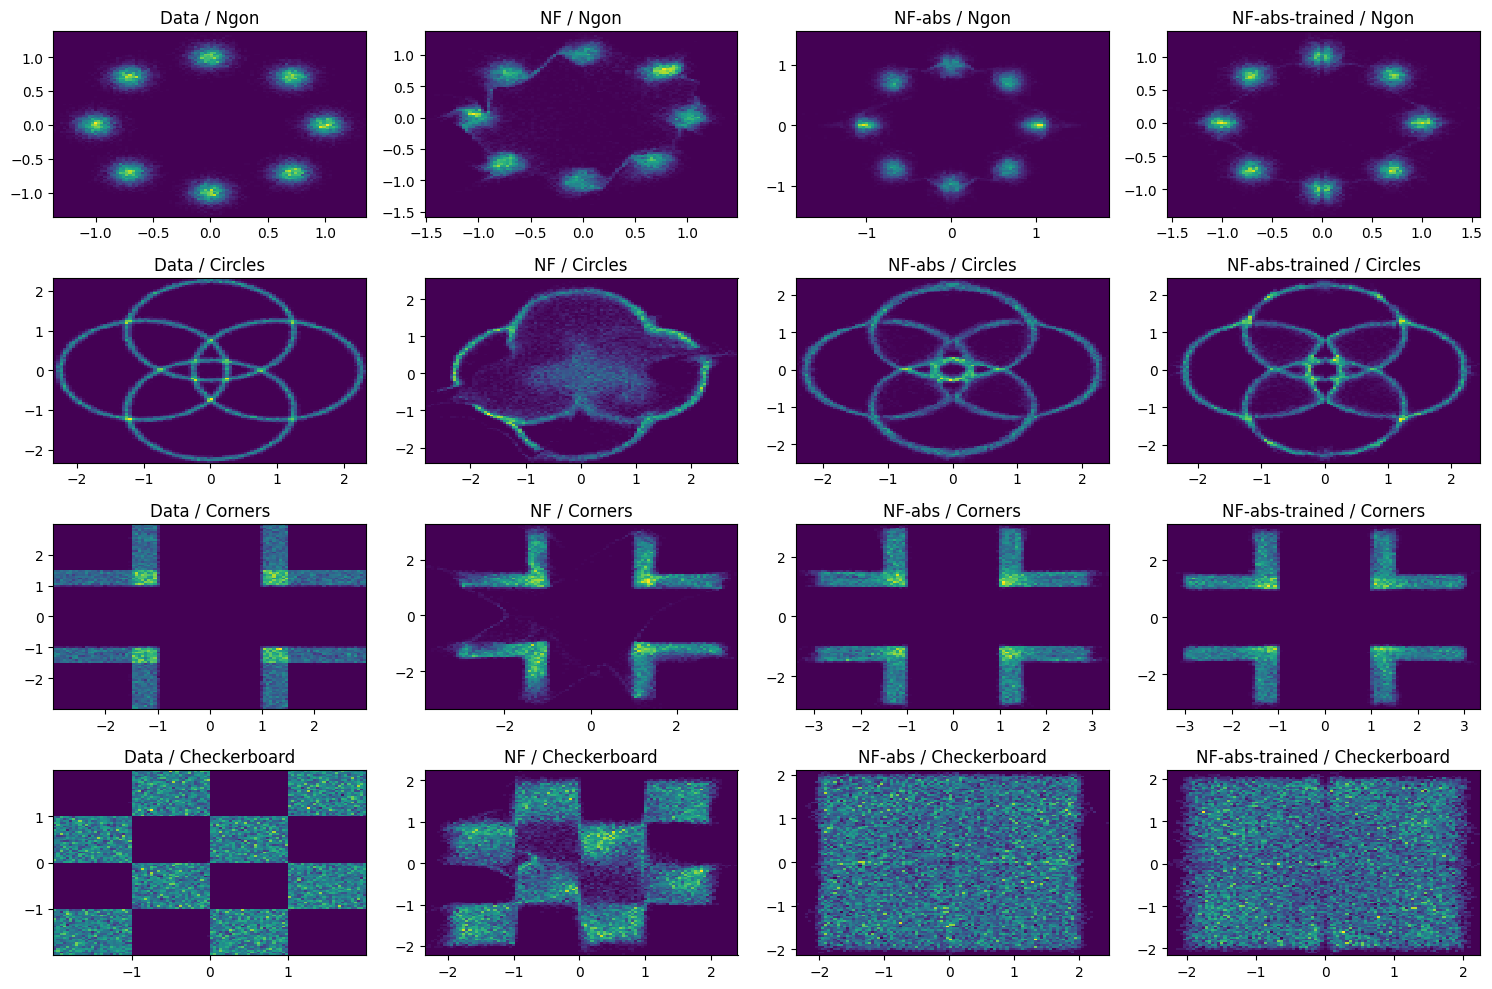

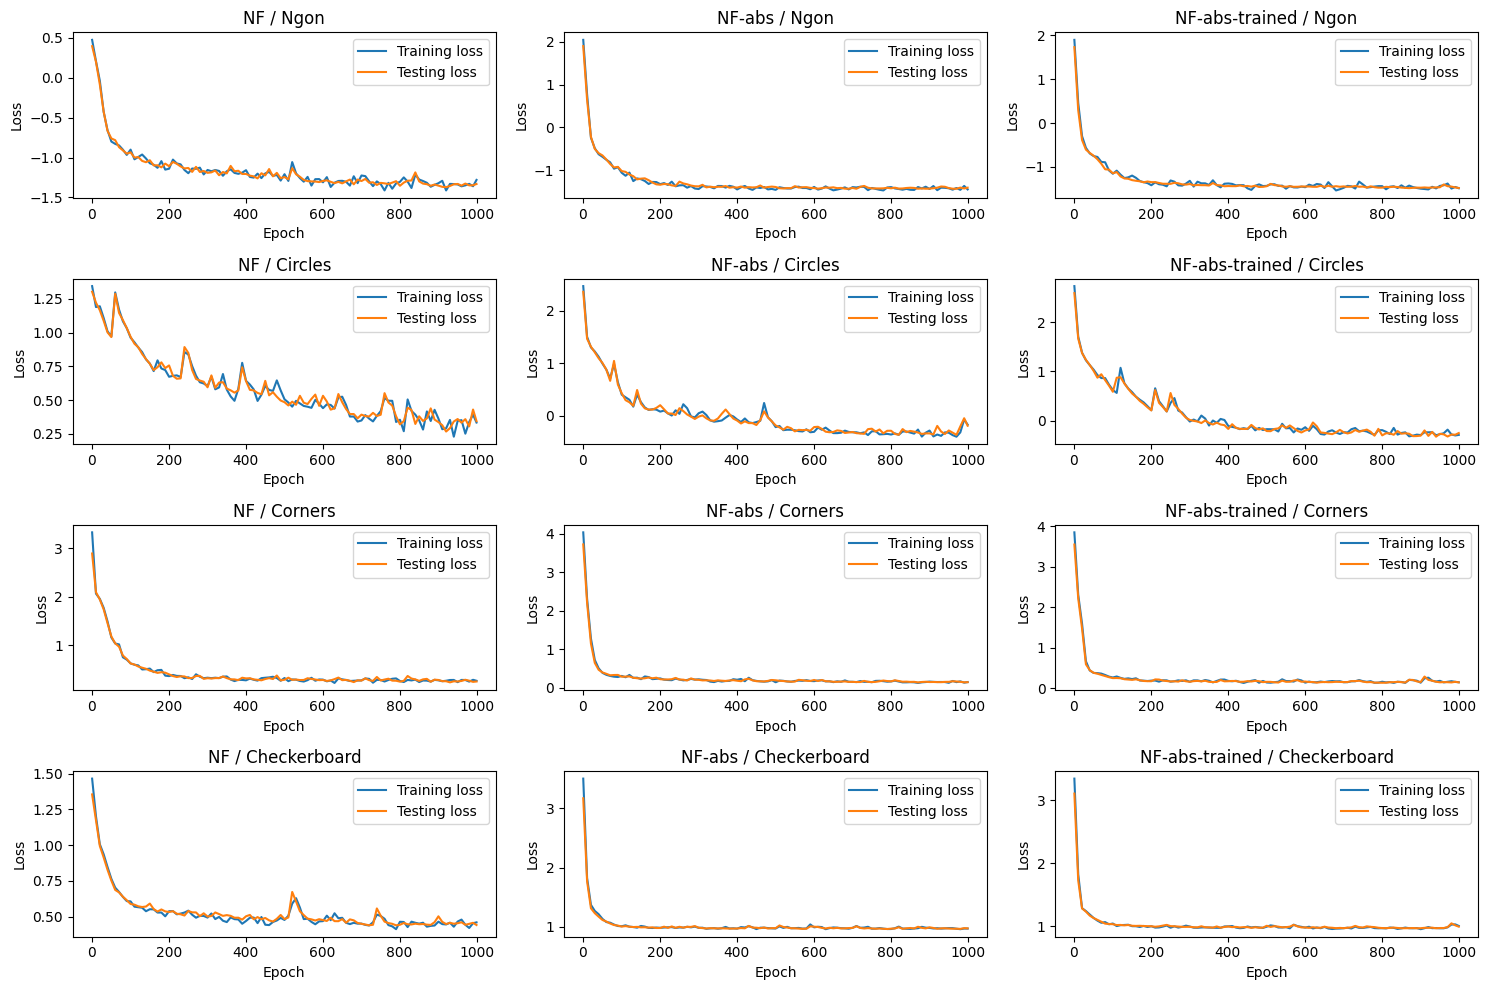

In [11]:
plot(models, default_datasets)

When looking at the ending losses, the plots reflect the observations above - the absolute layer is great for symmetric data but terrible for non-symmetric data.

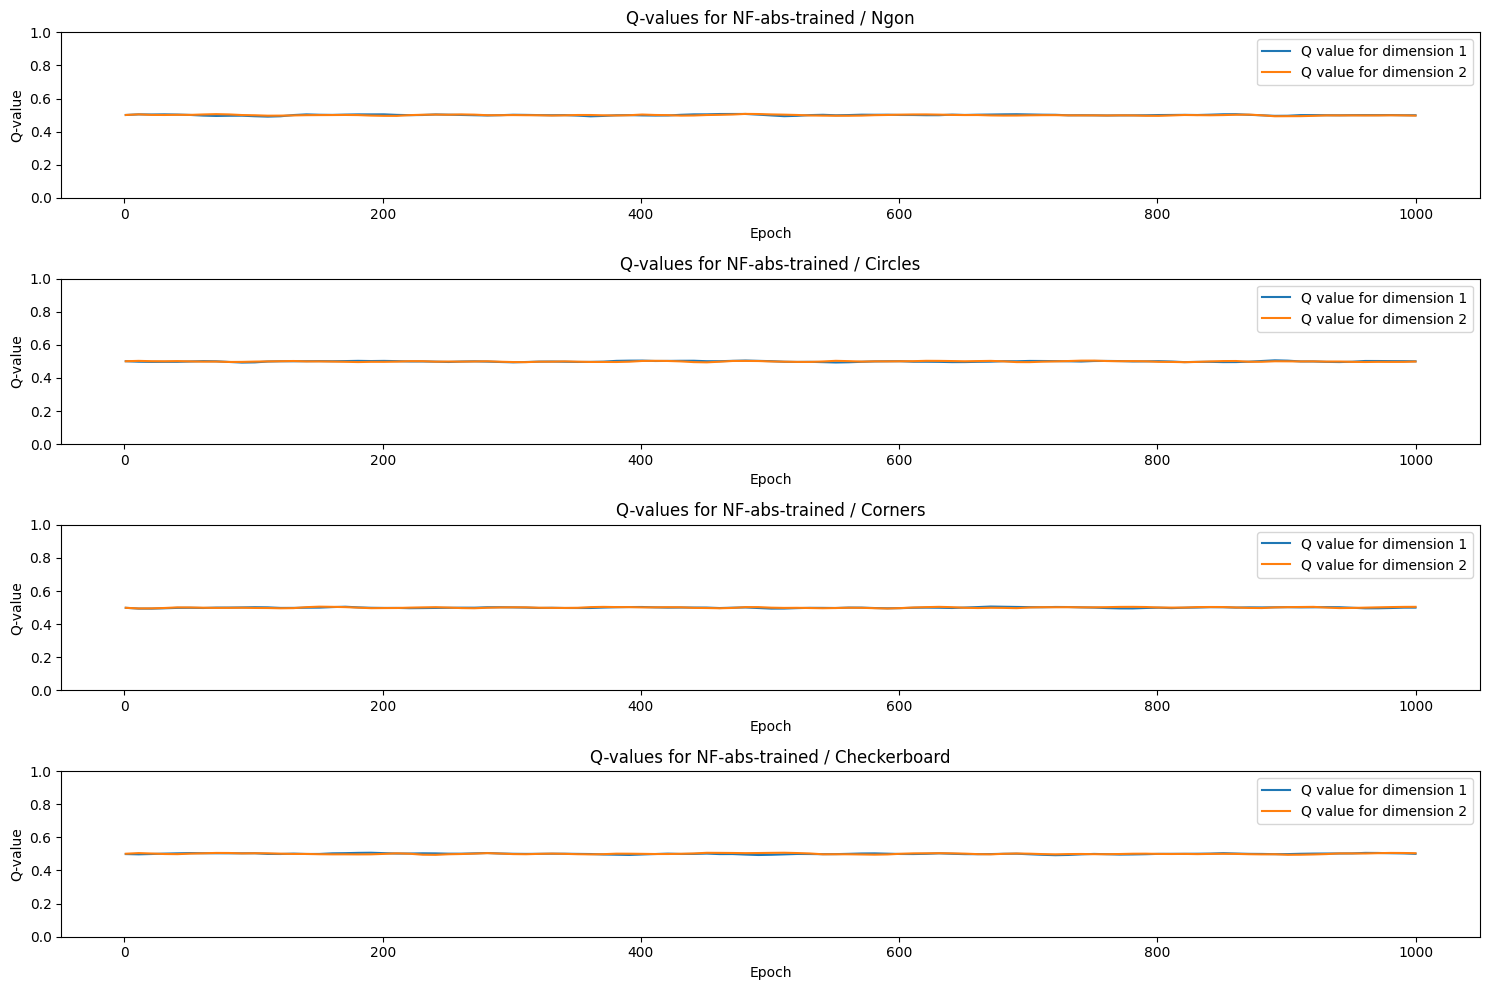

In [12]:
plot_q_values(models, default_datasets)

The Q-values for the absolute layer that influence the percentage of flipped values stay at 0.5, which makes sense since bot the symmetric/antisymmetric datasets are perfectly symmetric/antisymmetric.

To test whether the Q-values will be correctly learned for skewed data, we can modify the datasets to randomly `abs()` values in a given axis.

# Skewed Datasets

In [4]:
skewed_datasets = [
    Ngon(name="Skewed N-gon").skew(),
    Circles(name="Skewed Circles").skew(),
    Corners(name="Skewed Corners").skew(),
    Checkerboard(name="Skewed Checkerboard").skew(),
]

In [5]:
models = train_models(default_model_generators, skewed_datasets)

100%|██████████| 12/12 [14:20<00:00, 71.70s/it]


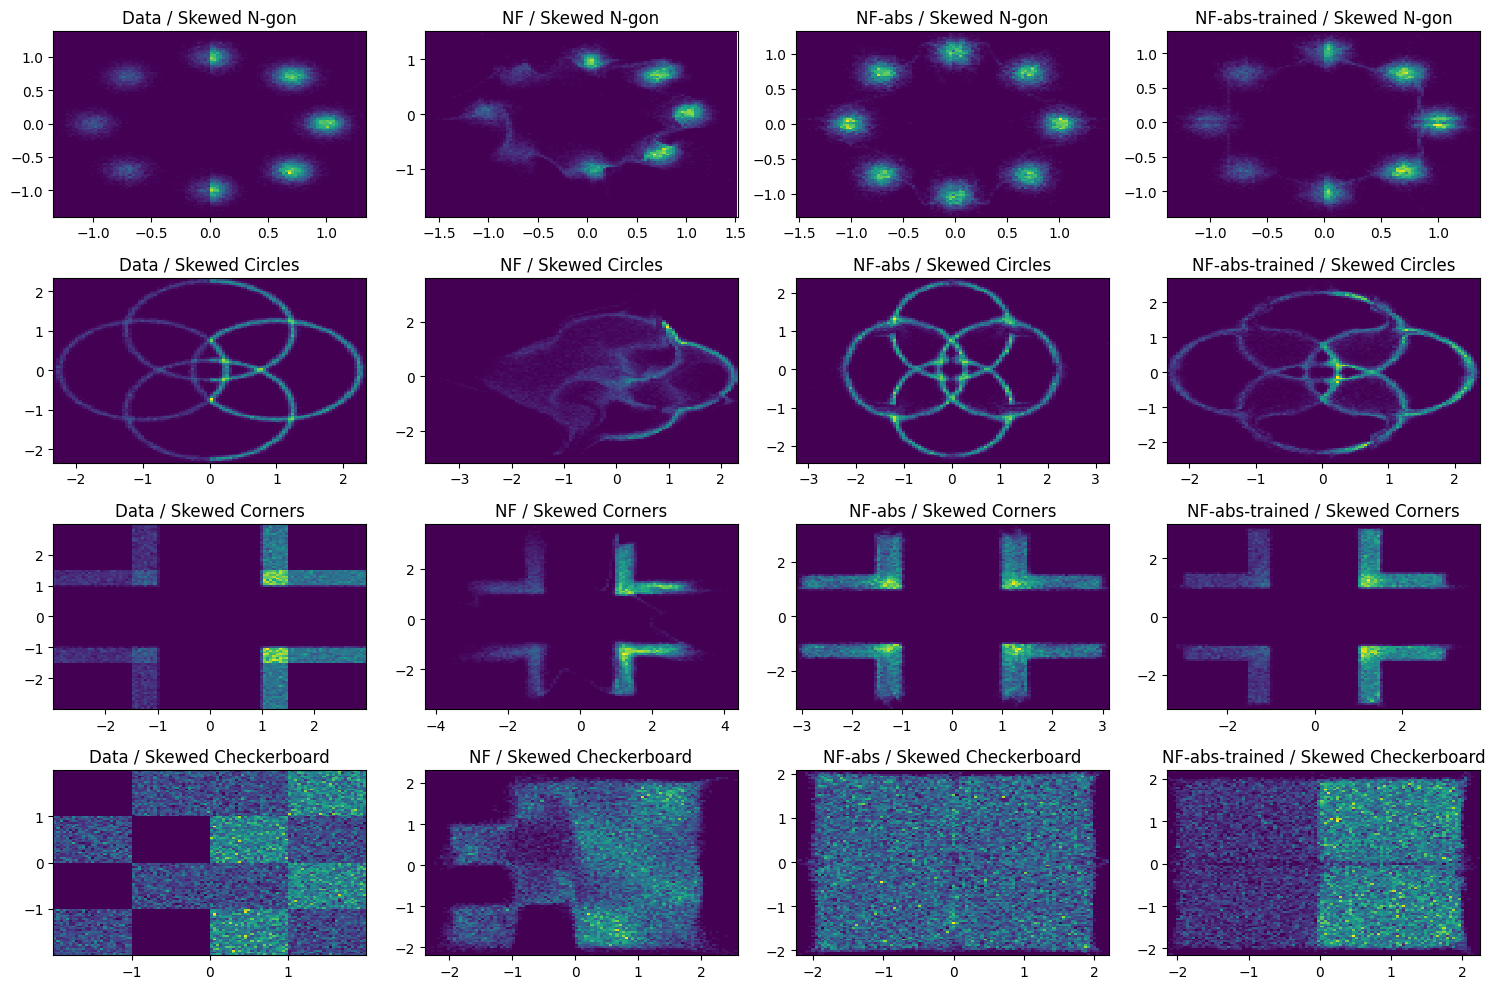

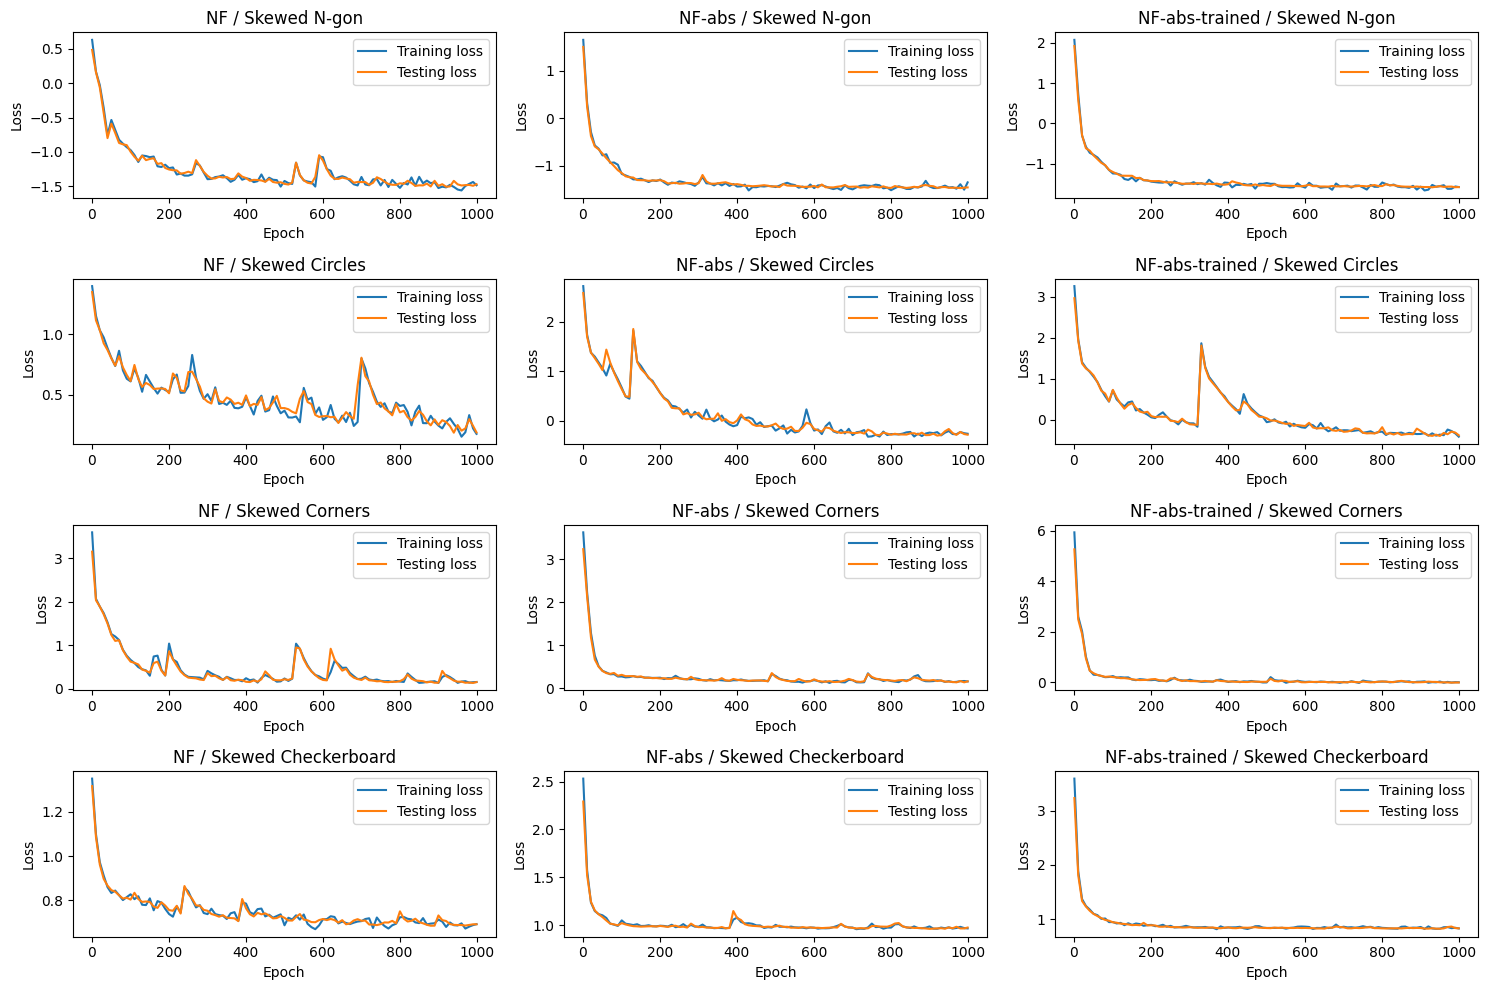

In [6]:
plot(models, skewed_datasets)

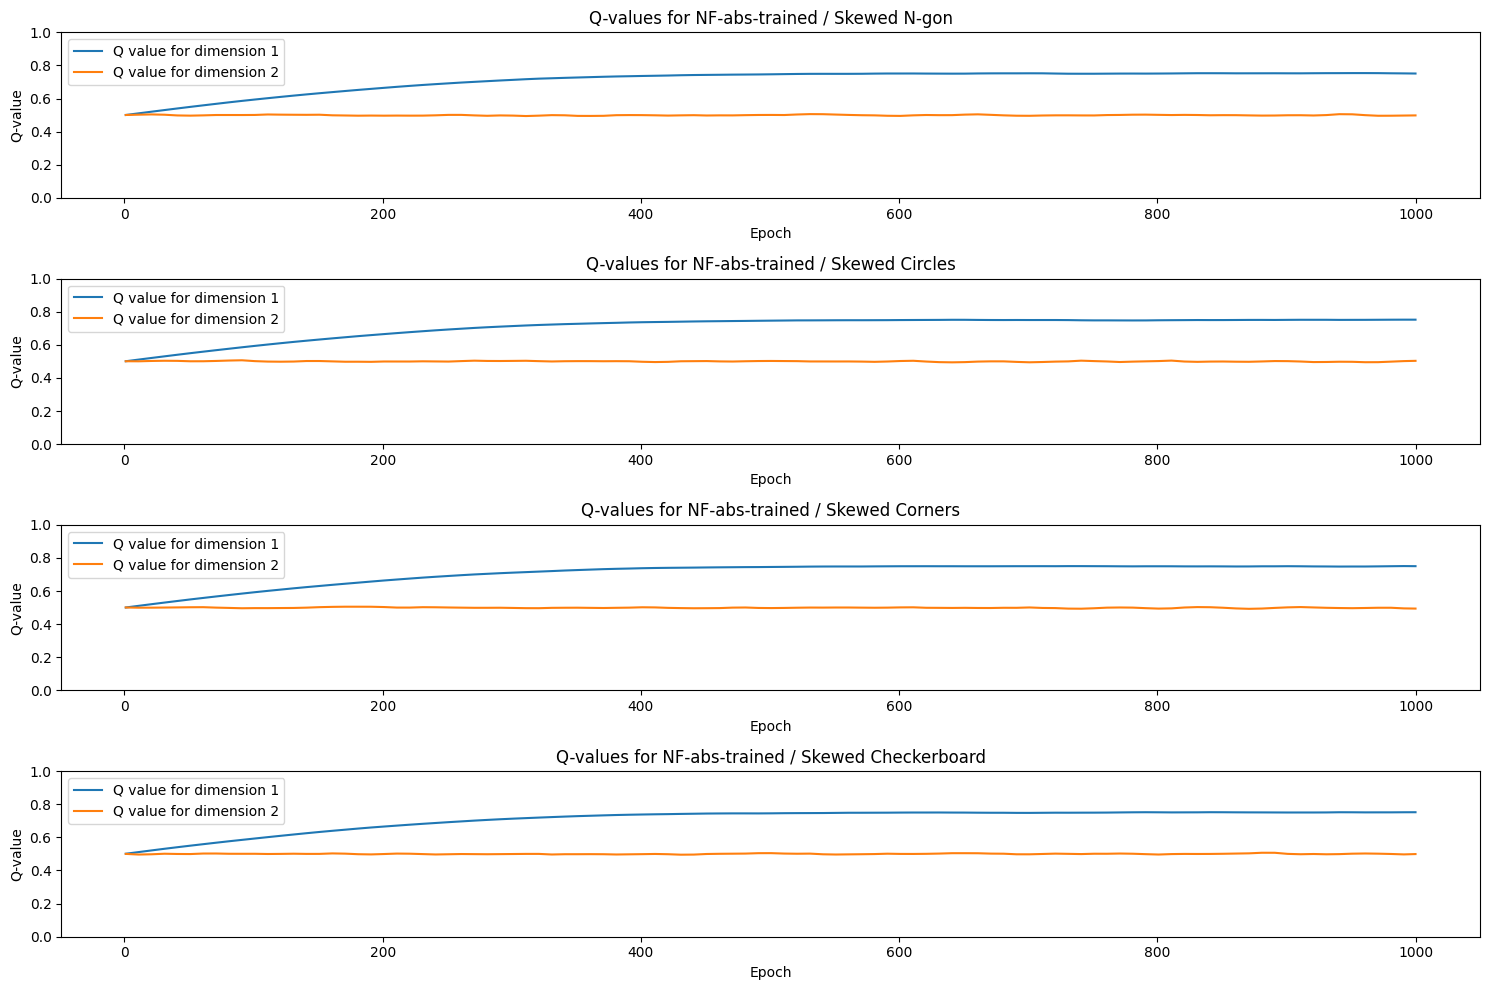

In [7]:
plot_q_values(models, skewed_datasets)

With the skew being 0.5, we move half of the data to the positive side, meaning that the split is 1/4 negative and 3/4 positive. This justifies the Q-value of 0.75.

# Offset Datasets

Offsetting the datasets breaks the current network structure because the absolute layer is at the very beginning.

In [16]:
vector = torch.tensor([1, 2])

offset_datasets = [
    Ngon(name="Offset N-gon").offset(vector),
    Circles(name="Offset Circles").offset(vector),
    Corners(name="Offset Corners").offset(vector),
    Checkerboard(name="Offset Checkerboard").offset(vector),
]

In [17]:
models = train_models(default_model_generators, offset_datasets)

100%|██████████| 12/12 [20:28<00:00, 102.42s/it]


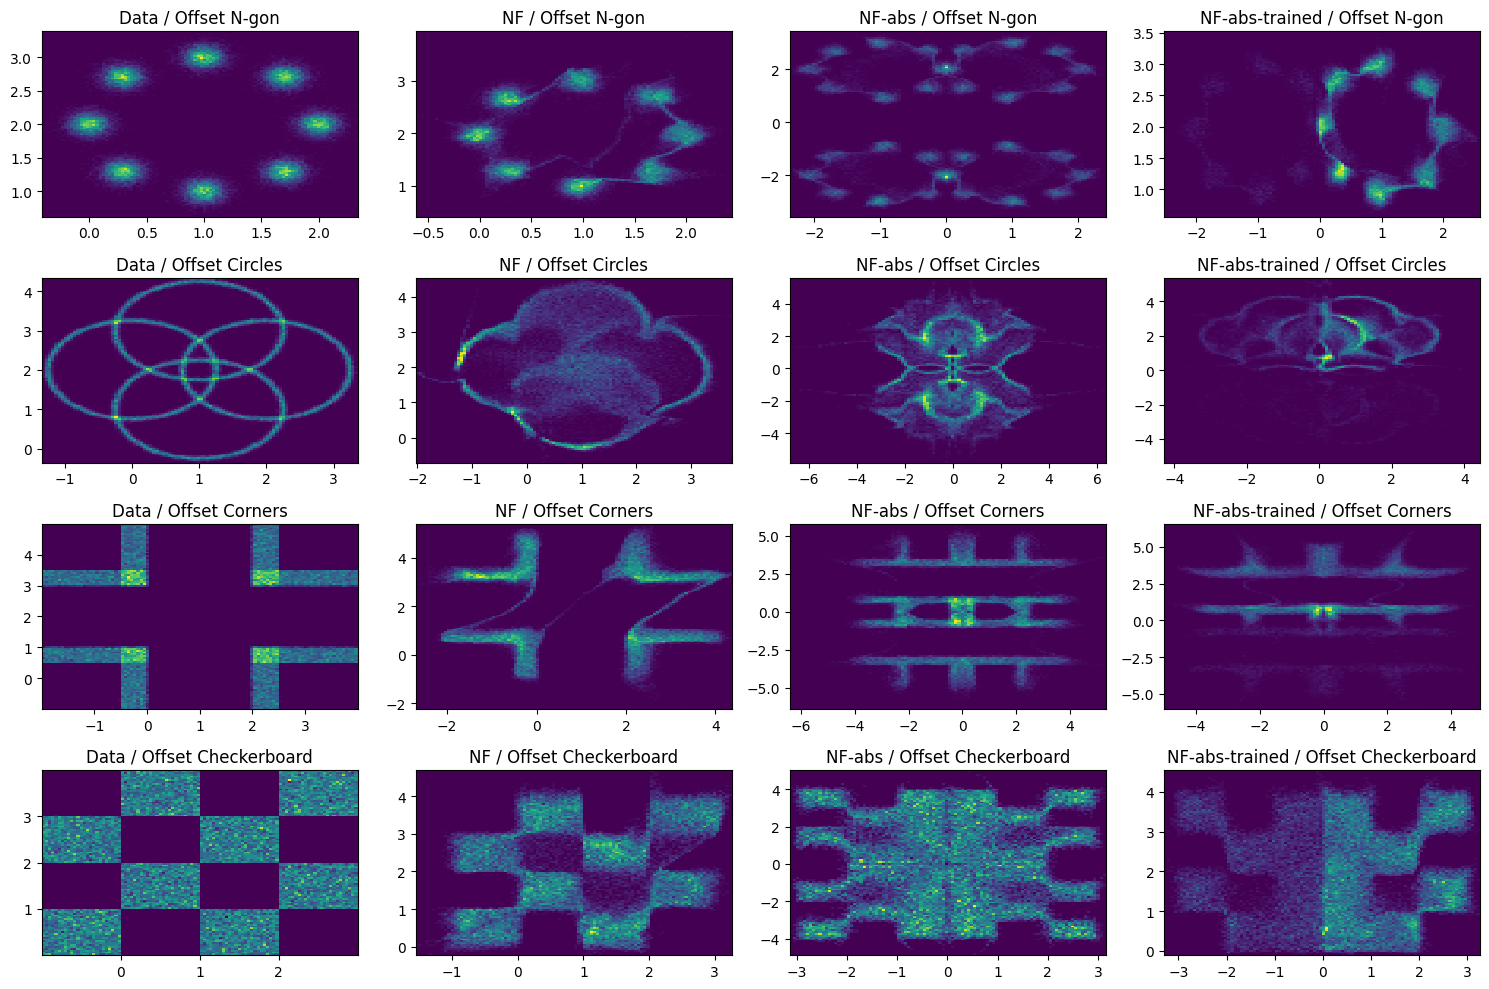

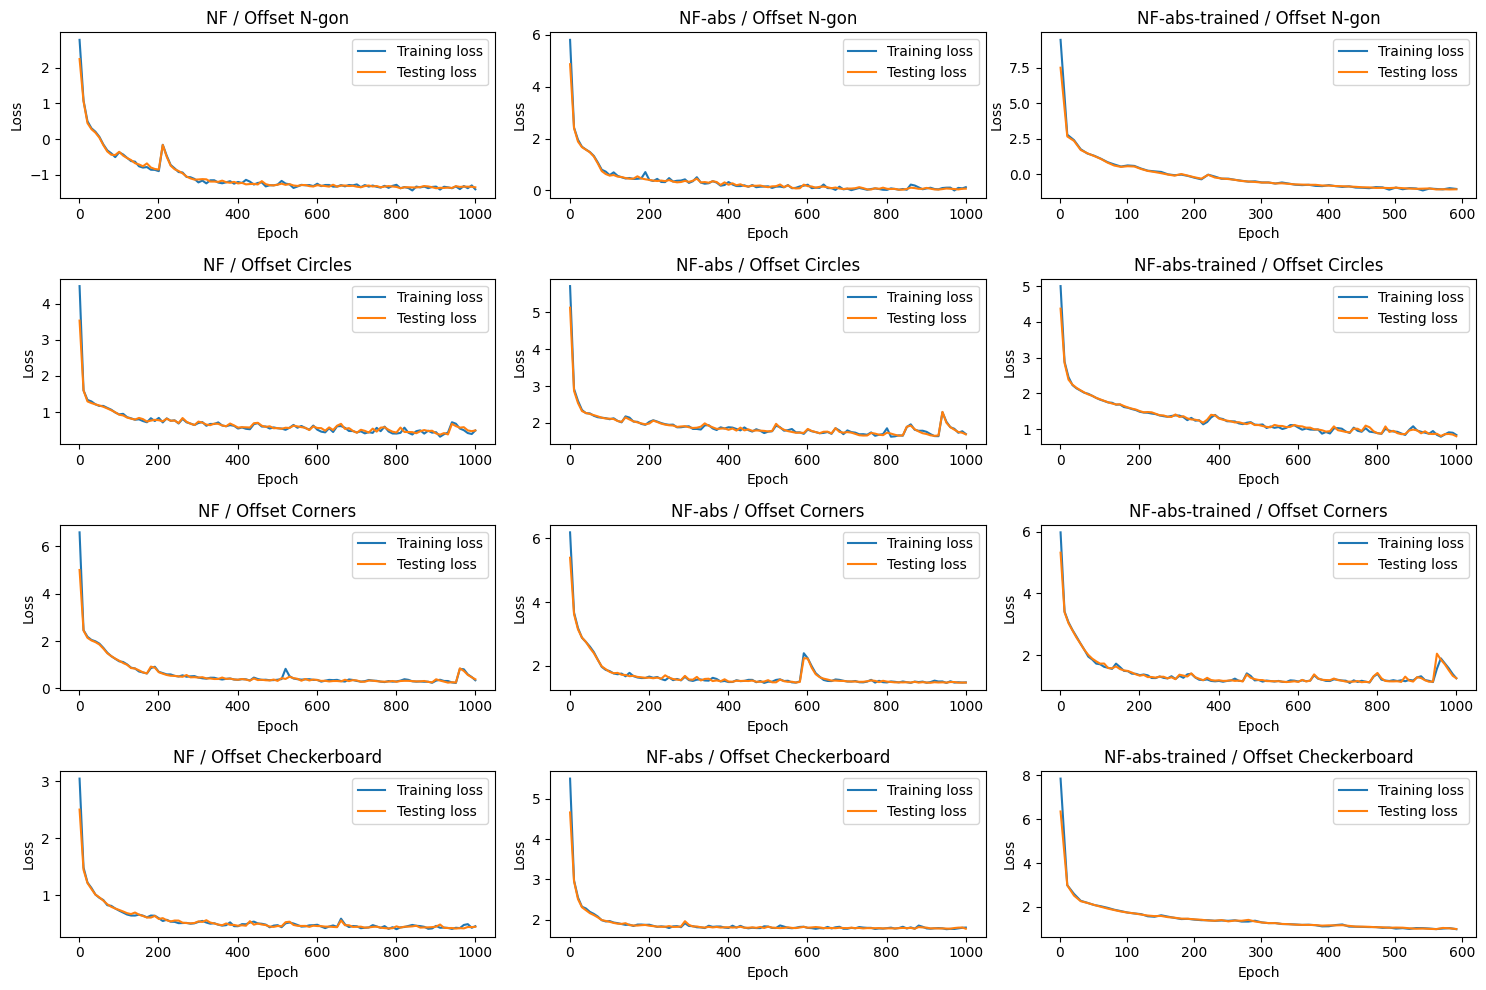

In [18]:
plot(models, offset_datasets)

To fix this, we can change the structure by moving it in the middle and let the bijective layers handle the transformation

In [3]:
middle_abs_model_generators = [
    lambda: SurVAE(
        [
            [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2)]
            for _ in range(10)
        ],
        name="NF",
    ),
    lambda: SurVAE(
        [
            [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2)]
            for _ in range(5)
        ] + [
            AbsoluteUnit(torch.tensor([1 / 2, 1 / 2])),
        ] + [
            [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2)]
            for _ in range(5)
        ],
        name="NF-middle-abs",
    ),
    lambda: SurVAE(
        [
            [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2)]
            for _ in range(5)
        ] + [
            AbsoluteUnit(torch.tensor([1 / 2, 1 / 2]), learn_q=True),
        ] + [
            [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2)]
            for _ in range(5)
        ],
        name="NF-middle-abs-trained",
    )
]

In [20]:
models = train_models(middle_abs_model_generators, offset_datasets)

100%|██████████| 12/12 [13:18<00:00, 66.56s/it]


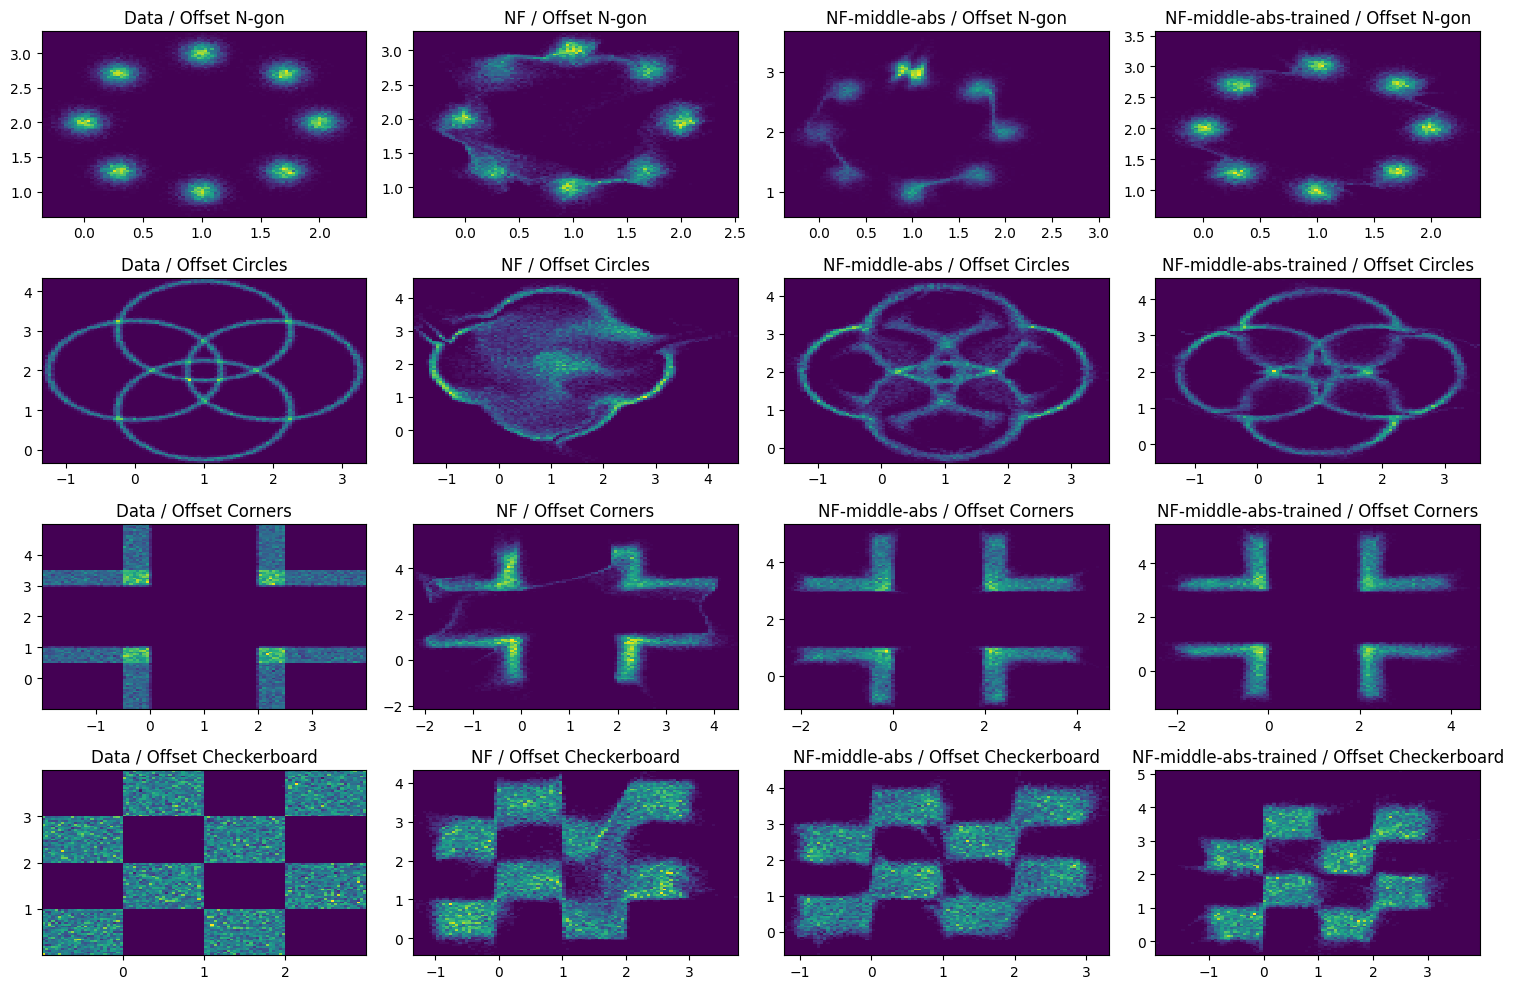

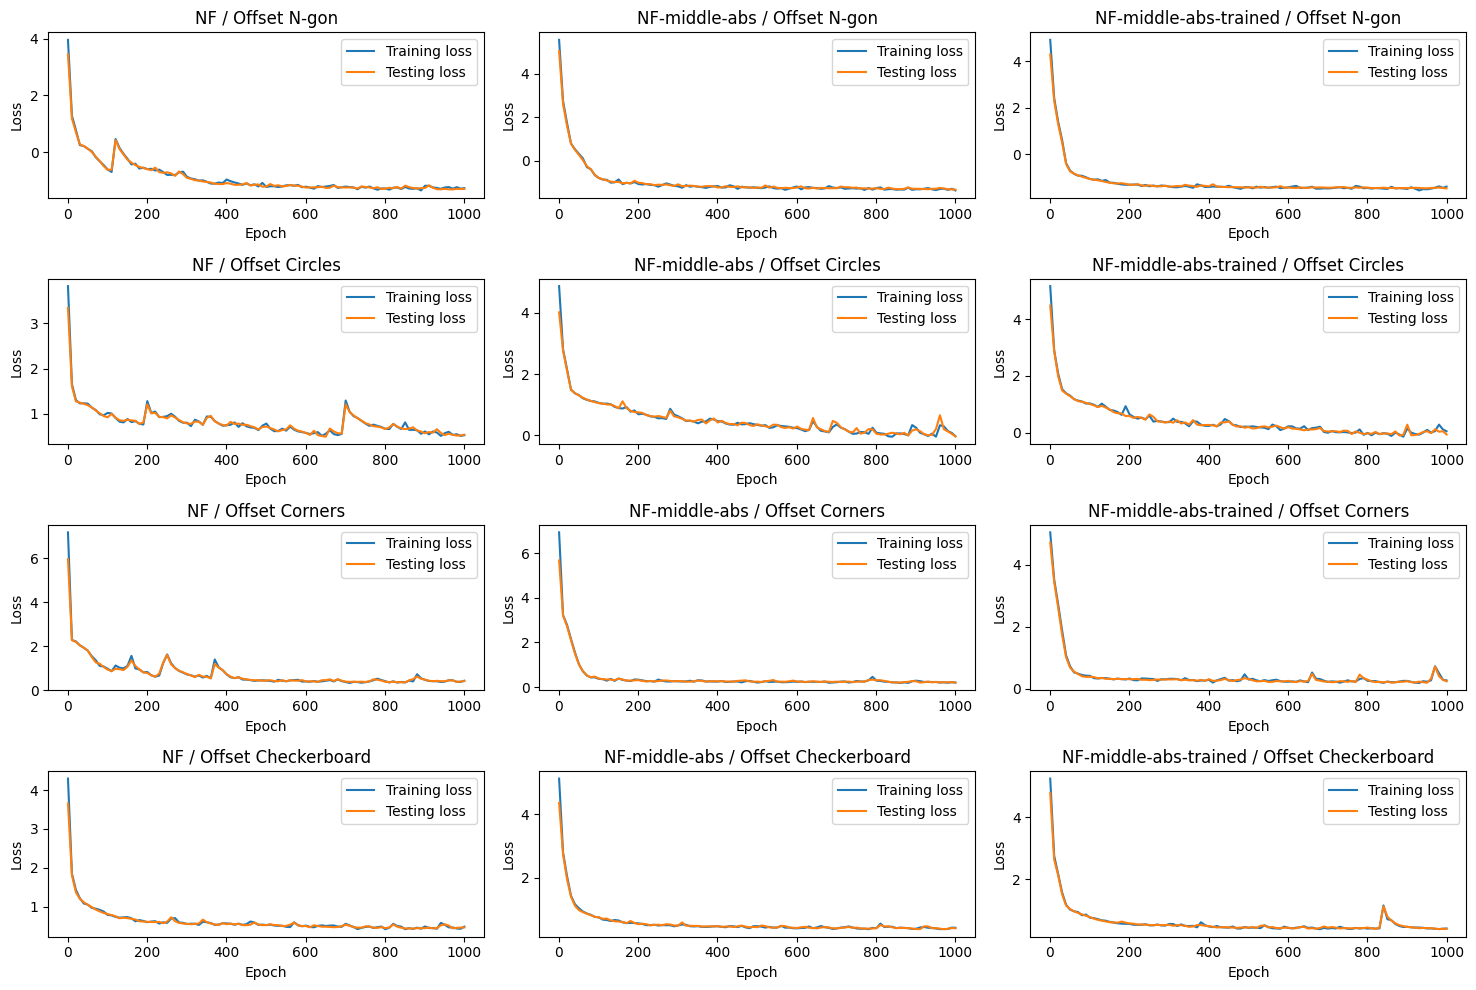

In [21]:
plot(models, offset_datasets)

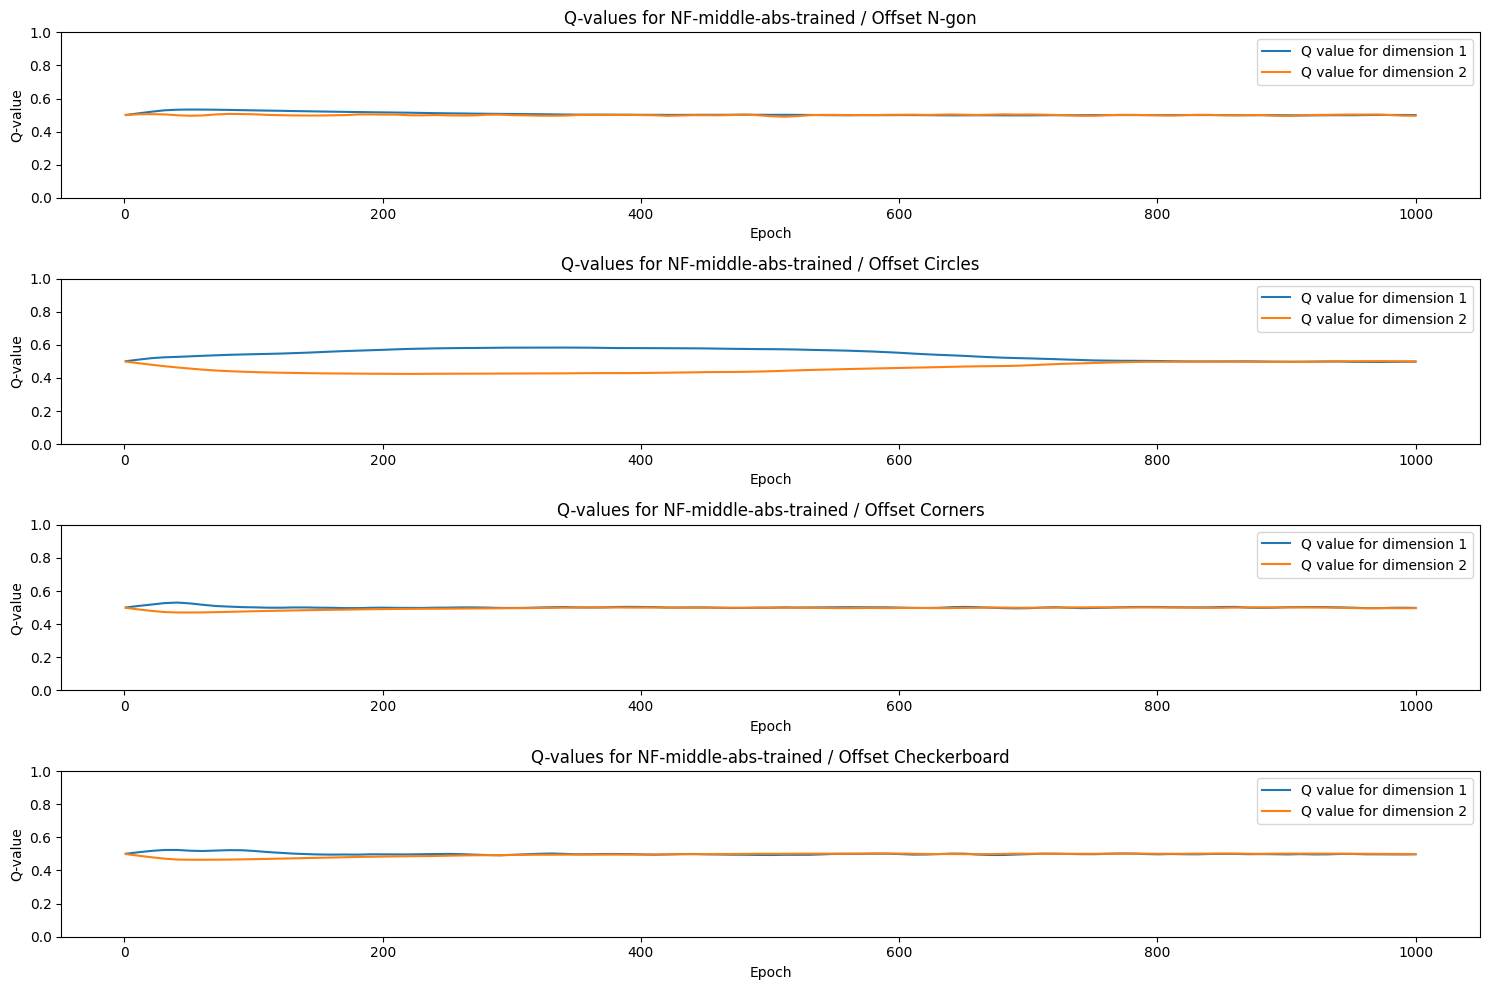

In [22]:
plot_q_values(models, offset_datasets)

# Anti-symmetric Datasets


In [23]:
anti_symmetric_datasets = [
    Gradient(name="Gradient (not cool)"),
    Gradient(name="Gradient (cool)", cool=True),
]

In [24]:
models = train_models(middle_abs_model_generators, anti_symmetric_datasets)

100%|██████████| 6/6 [06:40<00:00, 66.70s/it]


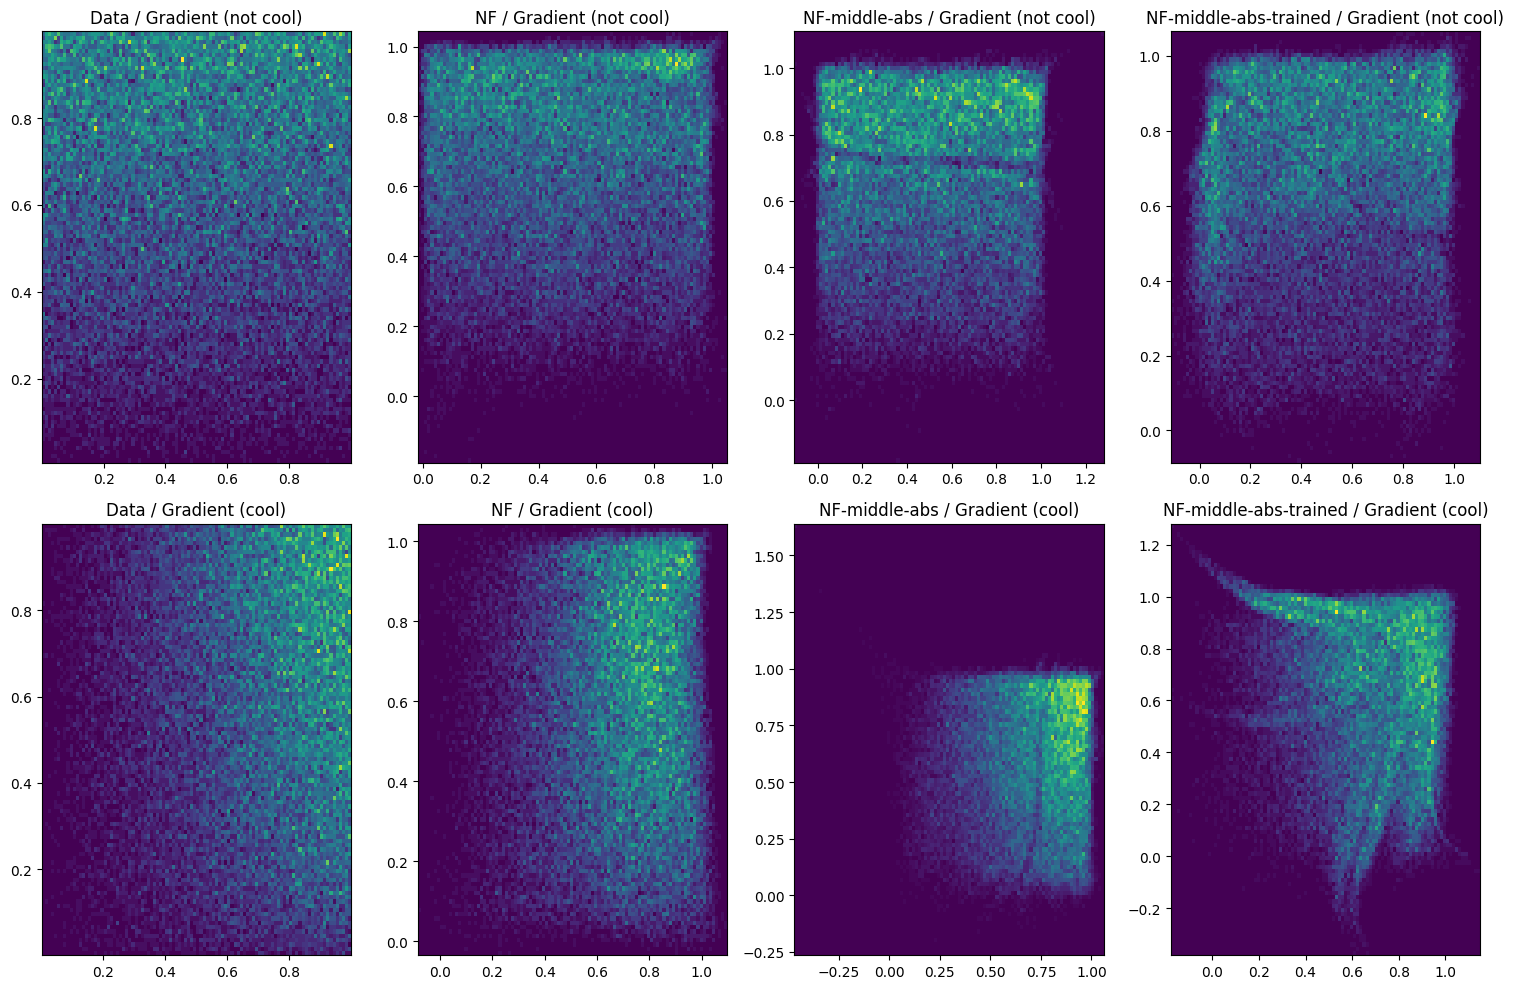

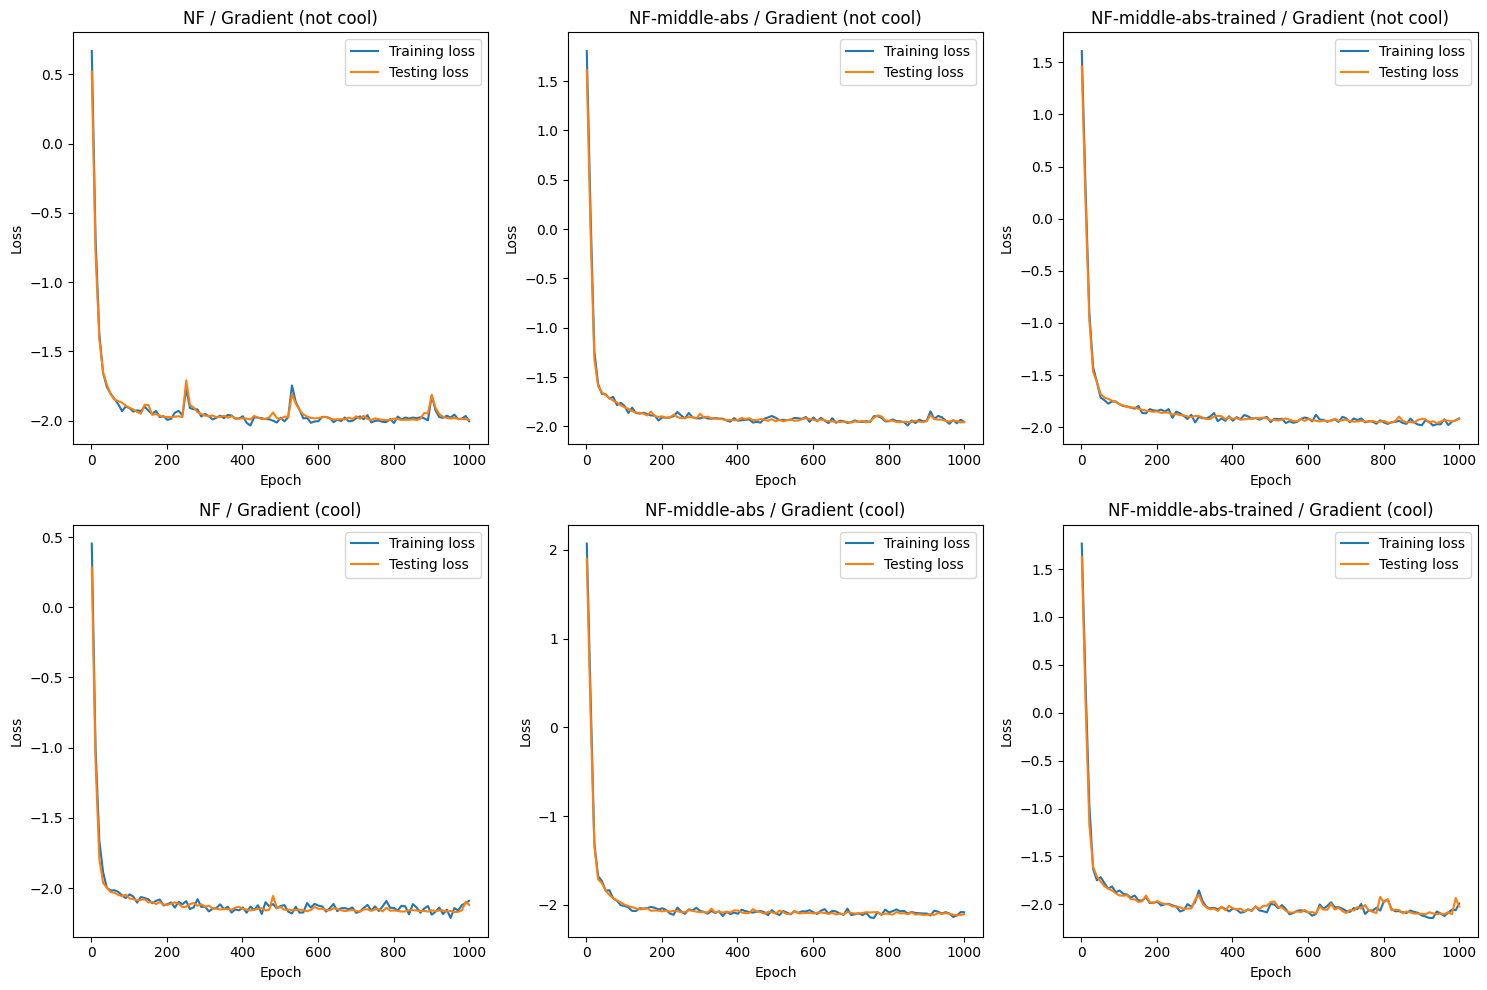

In [25]:
plot(models, anti_symmetric_datasets)

# Symmetry Visualization

In [4]:
checkerboard_model_generators = [middle_abs_model_generators[1]] * 4
checkerboard_datasets = [Checkerboard()] * 2 

In [12]:
def plot_symmetries(models, epochs_to_plot):
    """
    Plots the symmetries of the models.
    """
    dataset_count = max([i for i, _ in models]) + 1
    model_count = max([j for _, j in models]) + 1

    axis_len = 8  # sample length for axis visualization
    axis_n_samples = 10_000  # number of samples per axis
    distr_n_samples = 100_000  # number of samples for distribution


    for epoch in epochs_to_plot:
        fig, ax = plt.subplots(dataset_count, model_count, figsize=(model_count * 2, dataset_count * 2))

        for i in range(dataset_count):
            for j in range(model_count):
                model, states = models[i, j]
                model.load_state_dict(states[epoch].model_state)

                with torch.no_grad():
                    samples = model.sample(distr_n_samples).cpu().numpy()

                    _axis = torch.linspace(-axis_len, axis_len, axis_n_samples)
                    _zeros = torch.zeros(axis_n_samples)

                    x_axis = torch.stack((_axis, _zeros), dim=1)
                    y_axis = torch.stack((_zeros, _axis), dim=1)

                    for layer in reversed(model.layers[:9]):
                        x_axis = layer.backward(x_axis)
                        y_axis = layer.backward(y_axis)

                x_axis = x_axis.cpu()
                y_axis = y_axis.cpu()

                _ax = ax[i, j]

                _ax.hist2d(samples[:, 0], samples[:, 1], bins=100)
                _ax.scatter(x_axis[:, 0], x_axis[:, 1], s=1, c="red")
                _ax.scatter(y_axis[:, 0], y_axis[:, 1], s=1, c="yellow")

                _ax.set_xlim(-2, 2)
                _ax.set_ylim(-2, 2)
                _ax.set_aspect("equal")

                _ax.set_xticks([])
                _ax.set_yticks([])

        plt.tight_layout()
        plt.show()

In [6]:
models = train_models(checkerboard_model_generators, checkerboard_datasets, epochs=1000)

100%|██████████| 8/8 [08:31<00:00, 63.96s/it]


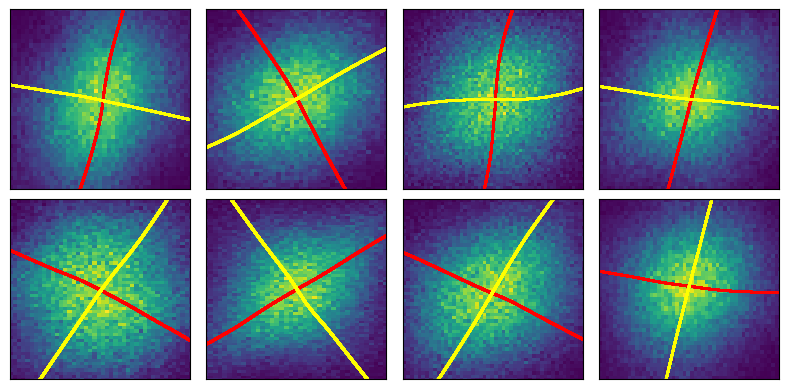

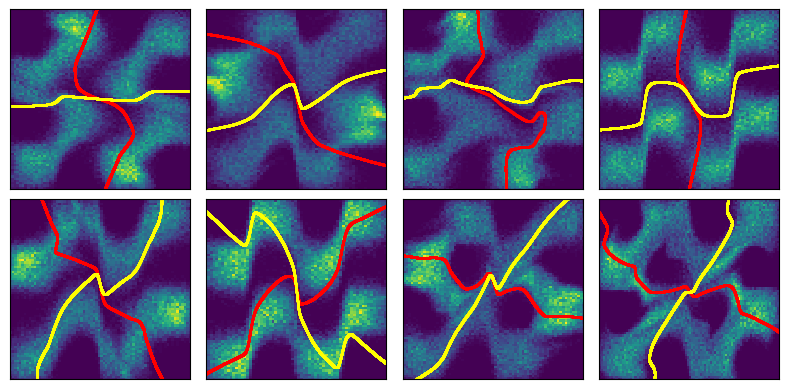

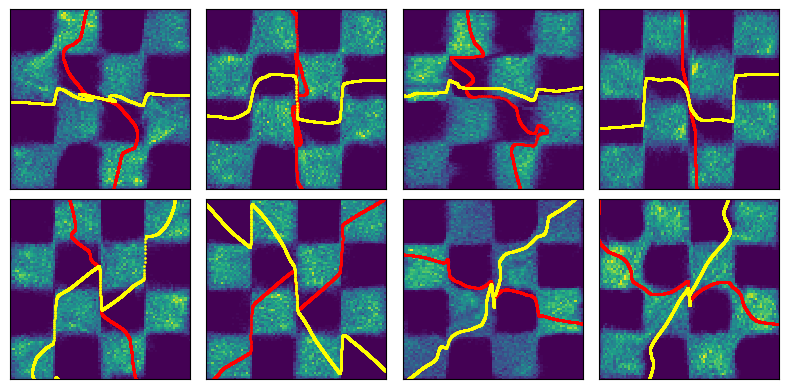

In [13]:
plot_symmetries(models, epochs_to_plot=[11, 101, 1000])